# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow tensorflow-io==0.36.0 matplotlib

## 1.2 Load Dependencies

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# 2. Build Data Loading Function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.1 Define Paths to Files

In [ ]:
CAPUCHIN_FILE = os.path.join('dat/content/drive/MyDrive/Data', '/content/drive/MyDrive/Data/Parsed_Capuchinbird_Clips/content/drive/MyDrive/Data/Parsed_Capuchinbird_Clips', '/content/drive/MyDrive/Data/Parsed_Capuchinbird_Clips/XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('dat/content/drive/MyDrive/Data', '/content/drive/MyDrive/Data/Parsed_Not_Capuchinbird_Clips', '/content/drive/MyDrive/Data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

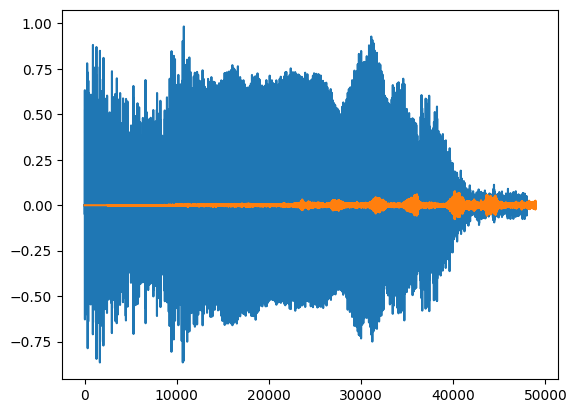

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [ ]:
POS = os.path.join('/content/drive/MyDrive/Data', '/content/drive/MyDrive/Data/Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/drive/MyDrive/Data', '/content/drive/MyDrive/Data/Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('/content/drive/MyDrive/Data', '/content/drive/MyDrive/Data/Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/Data', '/content/drive/MyDrive/Data/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [ ]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

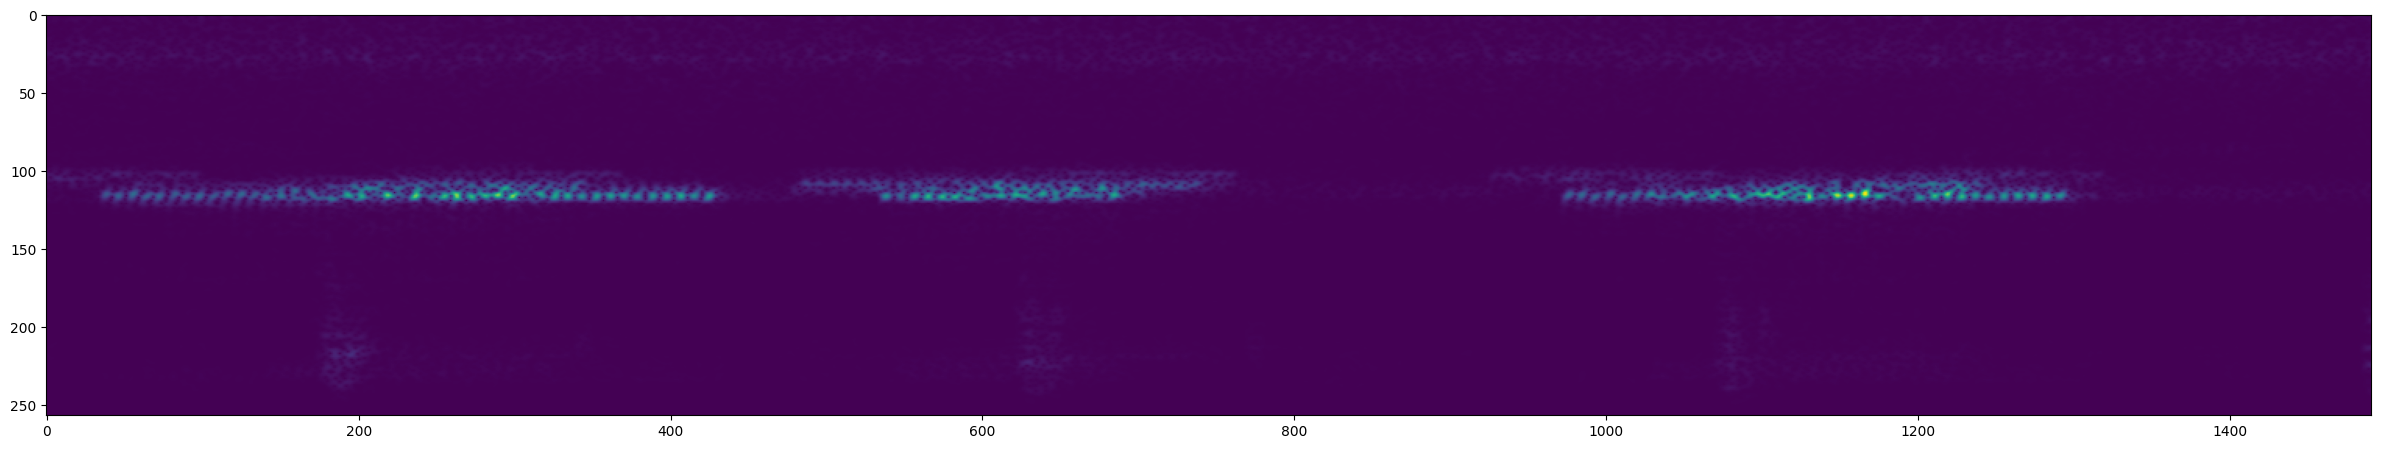

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:

model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 1)                 6019377   
                                                                 
Total params: 6021857 (22.97 MB)
Trainable params: 6021857 (22.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test )

Epoch 1/4
36/36 [==============================] - 15s 177ms/step - loss: 2.1803 - recall: 0.8776 - precision: 0.8323 - val_loss: 0.0136 - val_recall: 0.9846 - val_precision: 1.0000
Epoch 2/4
36/36 [==============================] - 5s 143ms/step - loss: 0.0743 - recall: 0.9615 - precision: 0.9868 - val_loss: 0.0392 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 5s 152ms/step - loss: 0.0314 - recall: 0.9872 - precision: 0.9872 - val_loss: 0.0034 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 5s 148ms/step - loss: 0.0079 - recall: 0.9935 - precision: 1.0000 - val_loss: 0.0010 - val_recall: 1.0000 - val_precision: 1.0000


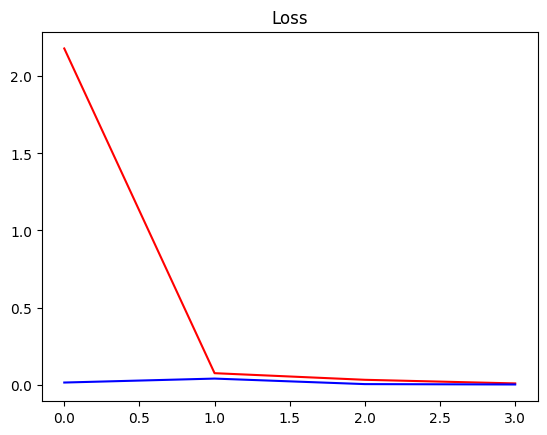

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

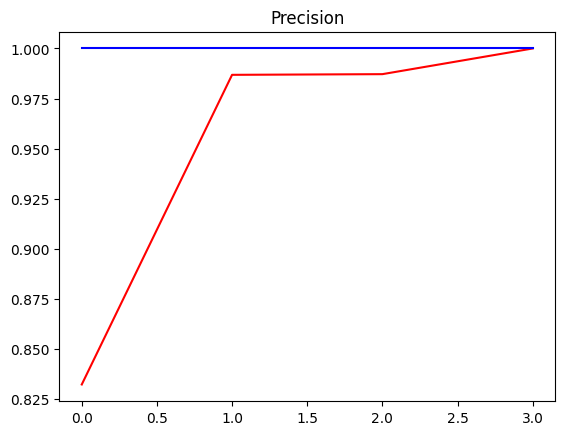

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()
#print(hist.history.keys())

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision'])


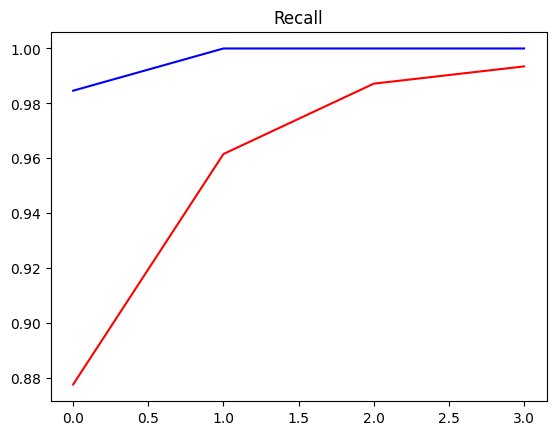

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 97ms/step


## 8.2 Convert Logits to Classes

In [ ]:
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('/content/drive/MyDrive/Data', '/content/drive/MyDrive/Data/Forest Recordings', '/content/drive/MyDrive/Data/Forest Recordings/recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(32)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

6/6 [==============================] - 5s 435ms/step


## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

5

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/Data', '/content/drive/MyDrive/Data/Forest Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/Data','/content/drive/MyDrive/Data/Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(32)

    yhat = model.predict(audio_slices)

    results[file] = yhat

2/2 [==============================] - 0s 147ms/step


In [ ]:
results

{'recording_07.mp3': array([[5.32717820e-07],
        [7.91457637e-08],
        [2.82349930e-08],
        [2.46810345e-07],
        [2.06158177e-07],
        [1.45868455e-07],
        [1.07076858e-07],
        [8.26670771e-07],
        [7.86968023e-02],
        [1.00000000e+00],
        [4.12569356e-08],
        [1.08406482e-06],
        [5.27935413e-07],
        [1.99188417e-08],
        [1.01381424e-07],
        [3.78313098e-06],
        [2.89683442e-07],
        [2.93496125e-08],
        [2.33740181e-07],
        [3.83244839e-07],
        [1.93886507e-07],
        [4.02319422e-08],
        [4.66084913e-07],
        [7.27086842e-07],
        [2.11638238e-07],
        [1.51085388e-07],
        [7.91748107e-07],
        [8.11122447e-07],
        [1.72541149e-07],
        [3.08982493e-08],
        [1.87988053e-06],
        [1.27899895e-07],
        [9.59265307e-08],
        [6.76699798e-08],
        [3.77368281e-07],
        [1.78181068e-07],
        [5.64580560e-08],
        [2.9767684

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_07.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_09.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_04.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0],
 'recording_05.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_07.mp3': 2,
 'recording_09.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_08.mp3': 24,
 'recording_06.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_00.mp3': 5,
 'recording_22.mp3': 2,
 'recording_16.mp3': 6,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_24.mp3': 0,
 'recording_23.mp3': 6,
 'recording_11.mp3': 4,
 'recording_20.mp3': 0,
 'recording_25.mp3': 15,
 'recording_19.mp3': 0,
 'recording_18.mp3': 2,
 'recording_17.mp3': 3,
 'recording_10.mp3': 5,
 'recording_21.mp3': 1,
 'recording_15.mp3': 2,
 'recording_12.mp3': 0,
 'recording_44.mp3': 1,
 'recording_29.mp3': 0,
 'recording_34.mp3': 4,
 'recording_39.mp3': 9,
 'recording_43.mp3': 5,
 'recording_30.mp3': 3,
 'recording_28.mp3': 15,
 'recording_40.mp3': 1,
 'recording_37.mp3': 3,
 'recording_35.mp3': 0,
 'recording_27.mp3': 0,
 'recording_41.mp3': 0,
 'recording_33.mp3': 0,
 'recording_36.mp3': 0,
 'recording_31.mp3': 1,
 'recording_3

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])